# Классификатор новостей на основе категорий yandex news

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers.core import Dense, Activation 
from keras import optimizers
from keras.preprocessing import sequence
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers import Dropout 
import pandas as pd
from stop_words import get_stop_words

np.random.seed(5) 

Using TensorFlow backend.


In [2]:
file_data = './data_sets/ya_posts_category.csv'

In [5]:
names=['id','text','category','auto','in_world','culture','saince','social','polit','accidents','sport','tehnology','economica']
df = pd.read_csv(file_data, names=names)
 

### Удаляем стоп слова

In [6]:
stop_words = get_stop_words('ru')

def filter_stop_words(text):
    global stop_words
    new_sent = [word for word in text.split() if word not in stop_words] 
    return ' '.join(new_sent)  
    
texts =  df['text'].map(filter_stop_words)
Y =  df[names[3:]].values

In [8]:
df.sample(3)

,id,text,category,auto,in_world,culture,saince,social,polit,accidents,sport,tehnology,economica
8129,1147466,москва февраля александра трусова побила миро...,Спорт,0,0,0,0,0,0,0,1,0,0
3521,429987,в стране восходящего солнца ситуацию с приоста...,В мире,0,1,0,0,0,0,0,0,0,0
9120,1148137,москва февраля прямые трансляции трех матчей ...,Спорт,0,0,0,0,0,0,0,1,0,0


### Разбиваем на тестовую и обучающею выборку

разюиваем корпус данных и обучаемся. Далее обрезаем все тексты до 150 слов.

In [12]:
nb_words = 25000
tokenizer = Tokenizer(num_words=nb_words)
tokenizer.fit_on_texts( texts ) 

X_raw = tokenizer.texts_to_sequences(texts)
X = sequence.pad_sequences(X_raw, maxlen=150)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=33)

### Вначале обучим модель на основе рекурентного слоя LSTM 

- слой LSTM 100
- полносвязный слой 100
- выход 10 классов

In [13]:
learning_rate = 0.005

model = Sequential()
model.add(Embedding(nb_words, 100, input_length= X_train.shape[1]))
model.add(LSTM(100))
model.add(Dropout(0.5))
 
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
 
model.add(Dense(10))
model.add(Activation('softmax'))

sgd = optimizers.Adam(lr=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=["accuracy"])

print( model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          2500000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
__________

Обучаем 10 эпох и валидируем на тестовой выборке

In [14]:
epochs_len = 10

result = model.fit(X_train, Y_train,
          epochs=epochs_len, 
          verbose=1, shuffle=True,
          callbacks=[],          
          validation_data=(X_test, Y_test),     
          )

Train on 7800 samples, validate on 1950 samples
Epoch 1/10
7800/7800 [==============================] - 52s 7ms/step - loss: 1.3104 - acc: 0.5467 - val_loss: 0.5281 - val_acc: 0.8062
Epoch 2/10
7800/7800 [==============================] - 54s 7ms/step - loss: 0.4134 - acc: 0.8744 - val_loss: 0.4581 - val_acc: 0.8697
Epoch 3/10
7800/7800 [==============================] - 58s 7ms/step - loss: 0.2616 - acc: 0.9258 - val_loss: 0.3993 - val_acc: 0.8882
Epoch 4/10
7800/7800 [==============================] - 60s 8ms/step - loss: 0.1770 - acc: 0.9449 - val_loss: 0.5186 - val_acc: 0.8841
Epoch 5/10
7800/7800 [==============================] - 52s 7ms/step - loss: 0.1742 - acc: 0.9442 - val_loss: 0.5250 - val_acc: 0.8795
Epoch 6/10
7800/7800 [==============================] - 50s 6ms/step - loss: 0.1502 - acc: 0.9517 - val_loss: 0.5866 - val_acc: 0.8897
Epoch 7/10
7800/7800 [==============================] - 53s 7ms/step - loss: 0.1630 - acc: 0.9500 - val_loss: 0.6260 - val_acc: 0.8836
Epoch 8

In [15]:
score = model.evaluate(X_test, Y_test, verbose=1)  
print ("Ошибка на тесте:  %f, точность на тесте: %f" % (score[0], score[1] ))

1950/1950 [==============================] - 3s 1ms/step
Ошибка на тесте:  0.628792, точность на тесте: 0.898974


Populating the interactive namespace from numpy and matplotlib


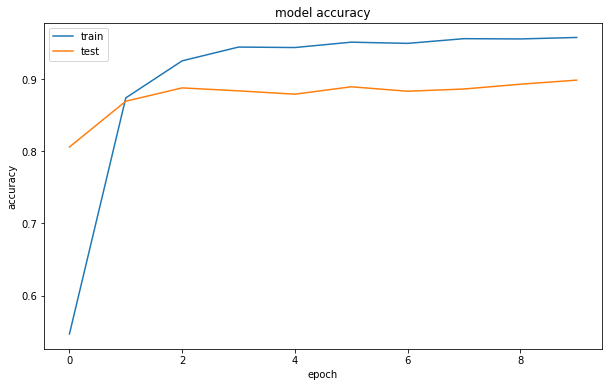

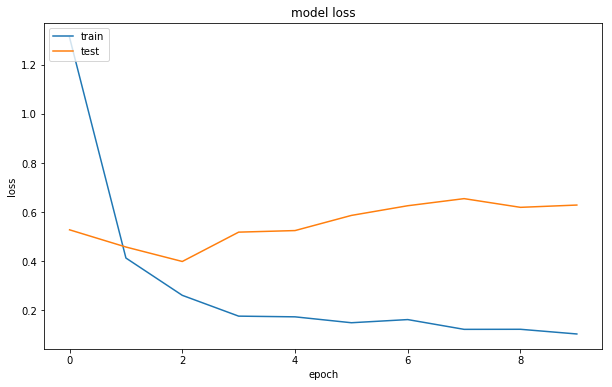

In [16]:
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

# summarize history for accuracy
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

- Из графиков видно, что ошибка на 3 эпохе стала рости. 
- Точность на 3 эпохе вышла на константу

### Скомбинируем  модель на основе рекурентного слоя LSTM и сверточного Conv1D (одномерный слой свертки)


- сверточный слой 32
- слой LSTM 100
- выход 10 классов

In [19]:
from keras.layers import Conv1D,MaxPooling1D

learning_rate = 0.005

model2 = Sequential( )
model2.add(Embedding( nb_words, 100, input_length= X.shape[1]))
model2.add (Conv1D (filters = 32 , kernel_size = 3 , padding='same', activation = 'relu') )
model2.add (MaxPooling1D (pool_size = 2 ))
model2.add(LSTM (100)) 
model2.add(Dense(10))
model2.add(Activation('softmax'))

sgd = optimizers.Adam(lr=learning_rate)
model2.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=["accuracy"]) 
print (model2.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 100)          2500000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 150, 32)           9632      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 75, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 2,563,842
Trainable params: 2,563,842
Non-trainable params: 0
_________________________________________________________________


Обучаем 10 эпох и валидируем на тестовой выборке

In [20]:
epochs_len = 10

result2 = model2.fit(X_train, Y_train,
          epochs=epochs_len, 
          verbose=1, shuffle=True,
          callbacks=[],          
          validation_data=(X_test, Y_test),     
          )

Train on 7800 samples, validate on 1950 samples
Epoch 1/10
7800/7800 [==============================] - 31s 4ms/step - loss: 0.9428 - acc: 0.6597 - val_loss: 0.4022 - val_acc: 0.8759
Epoch 2/10
7800/7800 [==============================] - 27s 3ms/step - loss: 0.2554 - acc: 0.9171 - val_loss: 0.3156 - val_acc: 0.9087
Epoch 3/10
7800/7800 [==============================] - 27s 4ms/step - loss: 0.1573 - acc: 0.9538 - val_loss: 0.3173 - val_acc: 0.9072
Epoch 4/10
7800/7800 [==============================] - 28s 4ms/step - loss: 0.1320 - acc: 0.9536 - val_loss: 0.3111 - val_acc: 0.9108
Epoch 5/10
7800/7800 [==============================] - 28s 4ms/step - loss: 0.1087 - acc: 0.9586 - val_loss: 0.3337 - val_acc: 0.9128
Epoch 6/10
7800/7800 [==============================] - 28s 4ms/step - loss: 0.0955 - acc: 0.9613 - val_loss: 0.3591 - val_acc: 0.9103
Epoch 7/10
7800/7800 [==============================] - 28s 4ms/step - loss: 0.0891 - acc: 0.9615 - val_loss: 0.3279 - val_acc: 0.9272
Epoch 8

In [22]:
score = model.evaluate(X_test, Y_test, verbose=1)  
print ("Ошибка на тесте:  %f, точность на тесте: %f" % (score[0], score[1] ))

1950/1950 [==============================] - 3s 1ms/step
Ошибка на тесте:  0.628792, точность на тесте: 0.898974


Populating the interactive namespace from numpy and matplotlib


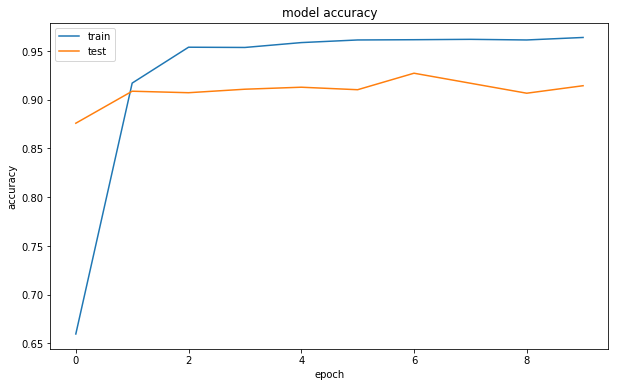

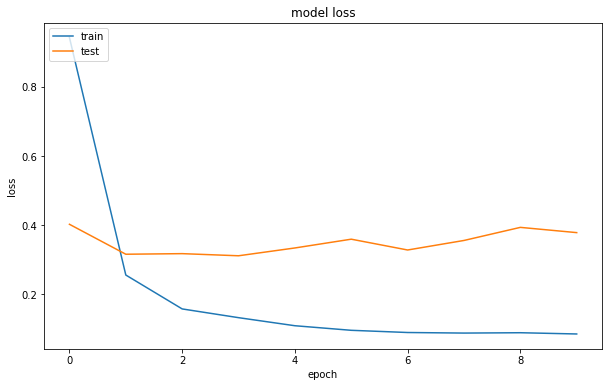

In [21]:
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

# summarize history for accuracy
plt.plot(result2.history['acc'])
plt.plot(result2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(result2.history['loss'])
plt.plot(result2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

- Из графиков видно, что ошибка на 3 эпохе стала рости. 
- Точность на 3 эпохе вышла на константу

### Скомбинируем  модель на основе полносвязных слоев


- полносвязный слой 100
- полносвязный слой 100
- выход 10 классов

In [43]:
learning_rate = 0.005

model3 = Sequential()
model3.add(Embedding(nb_words, 100, input_length= X_train.shape[1]))
model3.add(Dense(100))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
 
model3.add(Dense(100))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
 
model3.add(Dense(10))
model3.add(Activation('softmax'))

sgd = optimizers.Adam(lr=learning_rate)
model3.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=["accuracy"])

print( model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 150, 100)          2500000   
_________________________________________________________________
dense_19 (Dense)             (None, 150, 100)          10100     
_________________________________________________________________
activation_19 (Activation)   (None, 150, 100)          0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 150, 100)          0         
_________________________________________________________________
dense_20 (Dense)             (None, 150, 100)          10100     
_________________________________________________________________
activation_20 (Activation)   (None, 150, 100)          0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 150, 100)          0         
__________

In [44]:
epochs_len = 10
 
result3 = model3.fit(X_train, Y_train)
          # epochs=epochs_len, 
           #verbose=1, shuffle=True,
          #callbacks=[],  validation_data=(X_test, Y_test),    
          # )

ValueError: Error when checking target: expected activation_21 to have 3 dimensions, but got array with shape (7800, 10)